In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as ps
import matplotlib.pyplot as plt

from mygwr.gwr import GWR
from mygwr.sel_bw import Sel_BW
from libpysal.weights import lat2W

In [2]:
# Spatial eigenvector extraction function for making smooth simulated data

def extract_sf(w, style='B'):
    w.transform = style
    C, ids = ps.weights.full(w)
    n = C.shape[0]
    M = np.identity(n) - (float(1)/float(n))
    MCM = np.dot(np.dot(M,C),M)
    vals, vecs = np.linalg.eigh(MCM)
    vals, vecs = np.array(vals), np.array(vecs.T)
    #Sort vals and vecs because they aren't in decending order in python
    pairs = zip(vals, vecs)
    svals = sorted(vals, reverse=True)
    stups = [None] * len(svals)
    for e_val, vector in pairs:
        stups[svals.index(e_val)] = (e_val, vector)
        svals[svals.index(e_val)] = None
    vecs = np.array([x[1] for x in stups])
    vals = np.array([x[0] for x in stups])
    return vals, vecs

# Make data

In [3]:
size = 25
n = size**2
noiselvl = 0.25
Wlat = lat2W(nrows=25, ncols=25, rook=False)

evals, evecs = extract_sf(Wlat)
data = {'global' : 0.5*np.ones((size, size)),
        'regional' : evecs[0, :].reshape(size, size), 
        'local' : evecs[9, :].reshape(size, size)}
X = data['regional'].reshape(-1, 1)*1e3

betas = evecs[1, :].reshape(-1, 1)
y = X*betas + np.random.normal(loc=0, scale=noiselvl, size=(size**2, 1))

grids = np.meshgrid(range(size), range(size))
coords = np.hstack((grids[0].reshape(-1, 1), grids[1].reshape(-1, 1)))

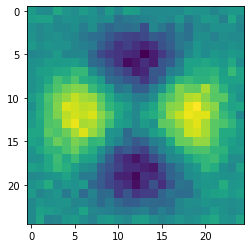

In [4]:
plt.imshow(y.reshape(size, size))

# Test my GWR

In [5]:
model = GWR(coords, y, X, 200).fit()

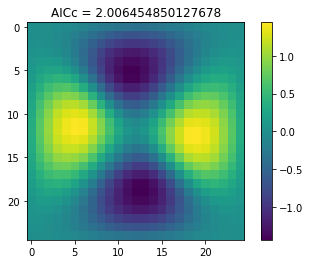

In [6]:
plt.imshow(model.predy.reshape(size, size))
plt.title(f'AICc = {model.loss()}')
plt.colorbar()

# Test my bandwidth selectors

In [7]:
golden_selector = Sel_BW(coords, y, X, optimizer='golden')
golden_results = golden_selector.select(bw_min=2, bw_max=200, full=True, tol=1e-7)

In [12]:
brent_selector = Sel_BW(coords, y, X, optimizer='brent')
brent_results = brent_selector.select(bw_min=2, bw_max=200, full=True, tol=1e-5)
brent_results

{'min': 199.13741503152184,
 'losses': 2.0064549122590254,
 'wall': 9.115574299998116}

In [11]:
pso_selector = Sel_BW(coords, y, X, optimizer='pso')
pso_results = pso_selector.select(n_particles=10, bw_min=2, bw_max=200, max_iter=25, tol=1e-6, inertia_wgt=1, full=True)
pso_results

{'min': 200.0,
 'loss': 2.006454850127678,
 'wall': 5.4792145999963395,
 'iters': 2}

In [13]:
grid_selector = Sel_BW(coords, y, X, optimizer='grid')
grid_results = grid_selector.select(bw_min=2, bw_max=200, full=True)

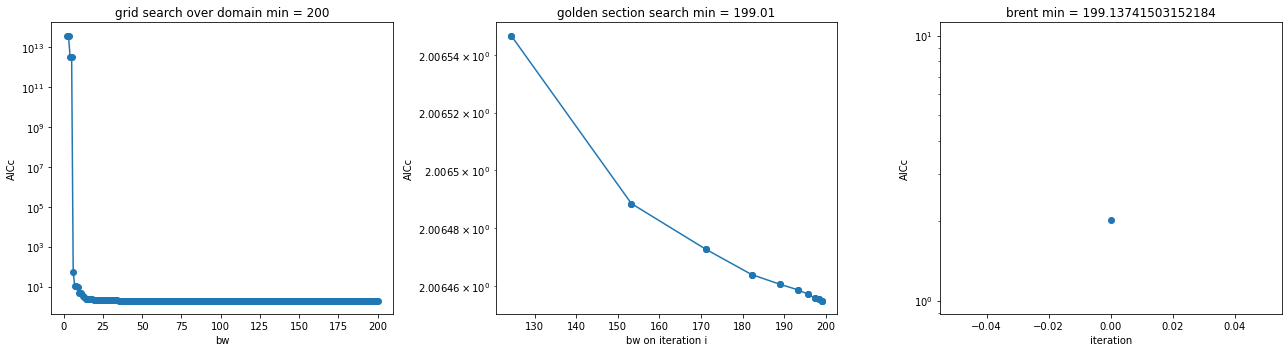

In [14]:
_, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 5))
ax1.semilogy(grid_results['candidates'], grid_results['losses'], '-o')
ax1.set_xlabel('bw')
ax1.set_ylabel('AICc')
ax1.set_title(f'grid search over domain min = {grid_results["min"]}')

ax2.semilogy(golden_results['candidates'], golden_results['losses'], '-o')
ax2.set_xlabel('bw on iteration i')
ax2.set_ylabel('AICc')
ax2.set_title(f'golden section search min = {golden_results["min"]}')

ax3.semilogy(brent_results['losses'], '-o')
ax3.set_xlabel('iteration')
ax3.set_ylabel('AICc')
ax3.set_title(f'brent min = {brent_results["min"]}')
plt.tight_layout()
plt.show()